In [1]:
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
from xgrid_utils import calc_spatial_integral

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
ds = xr.open_dataset('../data/era5_monthly.zarr')#.isel(time=slice(0, 50)).sel(latitude=slice(89, None), longitude=slice(-20, 20))

/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
ds

<xarray.Dataset>
Dimensions:    (time: 480, latitude: 101, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 65.0 65.25 65.5 65.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2018-12-31
Data variables: (12/19)
    d2m        (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    fg10       (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    mwd        (time, latitude, longitude) float32 ...
    mwp        (time, latitude, longitude) float32 ...
    ...         ...
    swh        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...

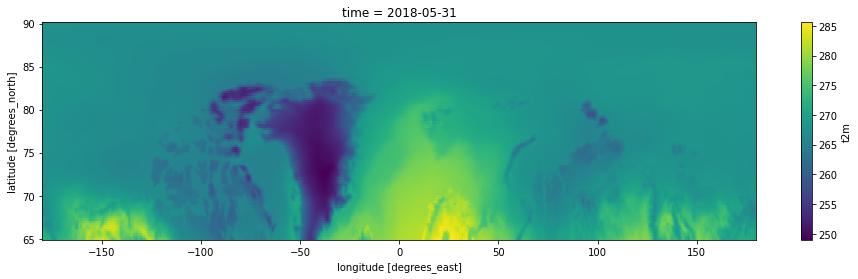

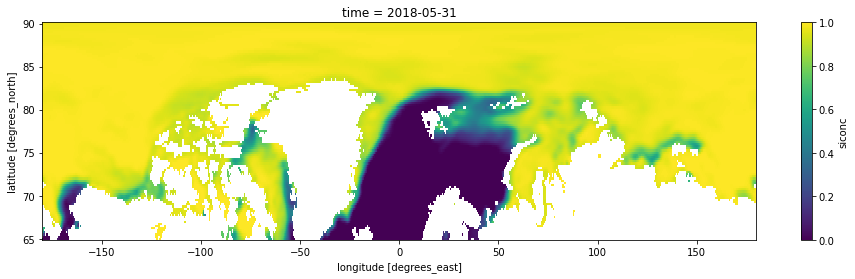

In [3]:
ds.isel(time=-8).t2m.plot(figsize=(16, 4))
ds.isel(time=-8).siconc.plot(figsize=(16, 4))

In [ ]:
ds_polar = ds.rio.write_crs(4326).rio.reproject(3995)

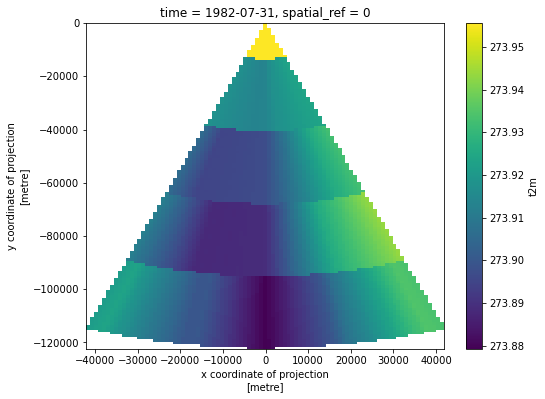

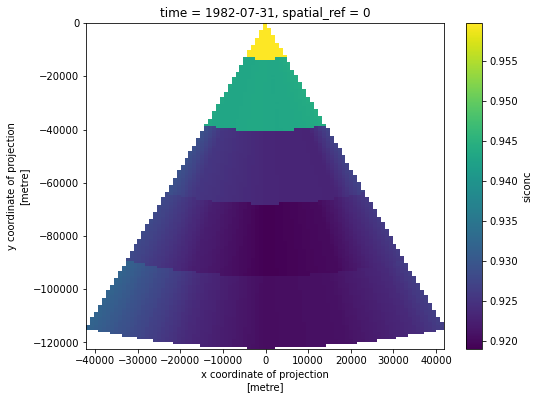

In [24]:
ds_polar.isel(time=-8).t2m.plot(figsize=(8, 6))
ds_polar.isel(time=-8).siconc.plot(figsize=(8, 6))

In [ ]:
ds_polar

In [25]:
# weights = np.cos(np.deg2rad(ds.latitude))
# extents = (ds.siconc > 0.15).weighted(weights).sum(dim=['latitude', 'longitude'])

extents = calc_spatial_integral(ds.siconc > 0.15) / 1000**2  # SIE in km2

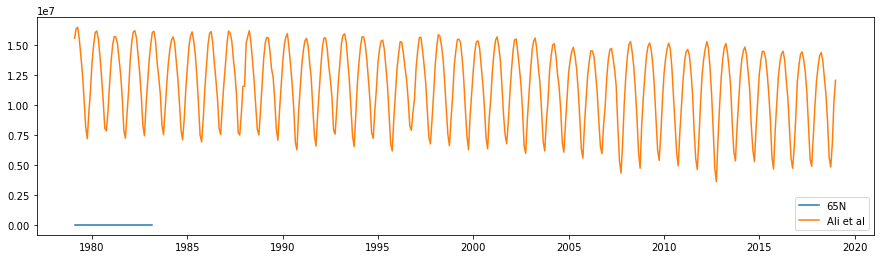

In [26]:
# Compare Ali's extents to ours (Ali = 25N)
extents_ali = np.load('../data/monthly_target.npy', allow_pickle=True)
month_range = pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2019, 1, 1), freq='M')

plt.figure(figsize=(15, 4))
plt.plot(ds_polar.time, extents, label='65N')
plt.plot(month_range, extents_ali, label='Ali et al')
plt.legend()

In [27]:
# Add timesteps to gridded and extent data
num_timesteps = 3

def create_timesteps(arr, num_timesteps=3):
    timesteps = [arr[:-(num_timesteps - 1)]]
    
    for i in range(1, num_timesteps - 1):
        timesteps.append(arr[i:-((num_timesteps-1)-i)])
                 
    timesteps.append(arr[(num_timesteps - 1):])
    return np.array(timesteps)

# Gridded
ds_timesteps = ds_polar.rolling(time=num_timesteps).construct('timesteps')
X_grid = np.array([ds_timesteps[var_] for var_ in ds_timesteps])
X_grid = X_grid.transpose((1, 4, 2, 3, 0))[num_timesteps - 1: -1]

# Extent
X_extent = create_timesteps(extents, num_timesteps).T[:-1]  # extents[num_timesteps: -1]  # create_timesteps(extents, num_timesteps).T
y_extent = np.expand_dims(extents[num_timesteps:], -1)

In [9]:
def split_time(ds, test_size):
    idx = int(len(ds.time) * (1 - test_size))
    train, test = ds.isel(time=slice(None, idx)), ds.isel(time=slice(idx, None))
    return train, test

In [28]:
print(X_grid.shape)  # samples, timesteps,  x, y, variables
print(X_extent.shape)  # samples, timesteps
print(y_extent.shape)  # samples, timesteps

(47, 3, 133, 91, 19)
(47, 3)
(47, 1)


In [52]:
test_size = 0.3

split_index = int(len(y_extent) * (1 - 0.3))

X_grid_train = X_grid[:split_index]
X_extent_train = X_extent[:split_index]
y_extent_train = y_extent[:split_index]

X_grid_test = X_grid[split_index + (num_timesteps - 1):]
X_extent_test = X_extent[split_index + (num_timesteps - 1):]
y_extent_test = y_extent[split_index + (num_timesteps - 1):]

In [31]:
# Construct the input layer with no definite frame size.
inp = layers.Masking()(layers.Input(shape=(num_timesteps, *X_grid.shape[2:])))
extent_inp = layers.Input(shape=(num_timesteps, 1))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    # dropout=0.2,
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    # dropout=0.2,
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
    # dropout=0.2,
)(x)
x = layers.Conv2D(
    filters=1, kernel_size=(3, 3), activation="relu", padding="same", data_format='channels_last',
)(x)

shape = [tf.shape(x)[k] for k in range(4)]
x = tf.reshape(x, [shape[0], shape[1]*shape[2]*shape[3]])  # Flattens

# LSTMify the input extents
x_extent = layers.LSTM(64, return_sequences=True)(extent_inp)
x_extent = layers.LSTM(32, return_sequences=True)(x_extent)
x_extent = layers.LSTM(1, return_sequences=False)(x_extent)

x = layers.Concatenate(axis=-1)([x, x_extent])
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(1)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model([inp, extent_inp], x)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 3, 133, 91,  0           []                               
                                 19)]                                                             
                                                                                                  
 conv_lstm2d_3 (ConvLSTM2D)     (None, 3, 133, 91,   531456      ['input_6[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 3, 133, 91,   256        ['conv_lstm2d_3[1][0]']          
 rmalization)                   64)                                                         

In [56]:
def get_batches(X, y, batch_size=10):
    n_samples = y.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    # np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start: end]
        
        # If multiple X inputs, yield as yield
        if isinstance(X, list):
            yield [x[batch_idx] for x in X], y[batch_idx]
        else:
            yield X[batch_idx], y[batch_idx]

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Hyperparameters
epochs = 2
batch_size = 10

# Fit 
history = model.fit(
    get_batches([X_grid_train, X_extent_train], y_extent_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=get_batches([X_grid_test, X_extent_test], y_extent_test, batch_size=batch_size),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/2
4/4 [==============================] - 35s 8s/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 2/2
4/4 [==============================] - 0s 15ms/step - loss: nan - lr: 0.0010
